# <font  color = "#0093AF">Paramagnetic Relaxation Enhancement</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter5/Ch5_PRE.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

Stochastic motion can modulate the Hamiltonian, leading to magnetization decay towards thermal equilibrium. Electron relaxation is similarly a stochastic process acting on the nucleus via the hyperfine coupling, and therefore will also lead to nuclear relaxation. This process is referred to as Paramagnetic Relaxation Enhancement (PRE), and manifests in a number of forms. We will investigate the impact of electron $T_1$ and $T_2$ on the nuclear $T_1$ and $T_2$ in the presence of an isotropic hyperfine coupling and a dipolar hyperfine coupling.

Note that modulation of the hyperfine coupling itself also leads to forms of paramagnetic relaxation, including the [Overhauser Effect](../Chapter4/Ch4_OverhauserEffect.ipynb), which was already discussed in the DNP chapter. We will not revisit these here, but be aware that hyperfine modulation will also play a role in transverse relaxation of the nucleus. 

In [0]:
# SETUP SLEEPY
import sys
if 'google.colab' in sys.modules:
  !pip install sleepy-nmr

## Setup

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
sl.Defaults['verbose']=False

## PRE from an isotropic hyperfine coupling


### Build the system
We start with an electron nuclear system, with an isotropic hyperfine coupling

In [3]:
ex=sl.ExpSys(v0H=500,Nucs=['13C','e-'],LF=True)
aiso=5e5
ex.set_inter(Type='hyperfine',i0=0,i1=1,Axx=aiso,Ayy=aiso,Azz=aiso)    #Hyperfine coupling

L=ex.Liouvillian()

### Electron $T_2$ relaxation only

In [4]:
L.clear_relax()
L.add_relax('T2',i=1,T2=1e-13)
seq=L.Sequence(Dt=1.01e-3)

rho=sl.Rho('13Cx+13Cz',['13Cp','13Cz','ez'])
_=rho.DetProp(seq,n=10000)

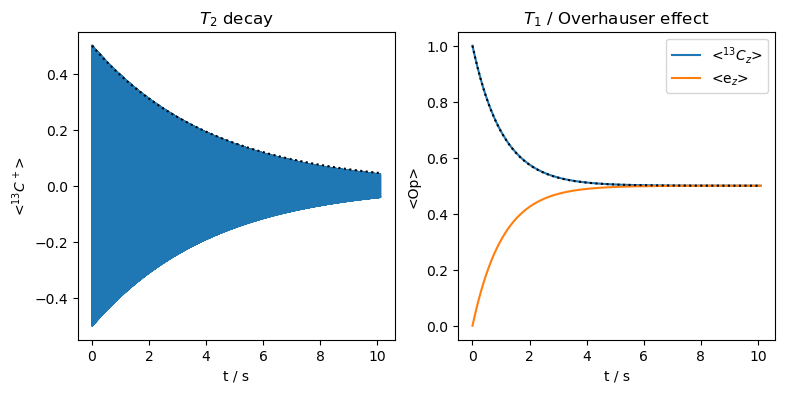

In [5]:
rho.downmix()
T1=2.1
ax=plt.subplots(1,2,figsize=[9,4])[1]
rho.plot(axis='s',det_num=0,ax=ax[0])
ax[0].set_title('$T_2$ decay')
ax[0].plot(rho.t_axis,0.5*np.exp(-rho.t_axis/(T1*2)),color='black',linestyle=':')
rho.plot(axis='s',det_num=[1,2],ax=ax[1])
ax[1].set_title(r'$T_1$ / Overhauser effect')
_=ax[1].plot(rho.t_axis,np.exp(-rho.t_axis/(T1/2))*0.5+0.5,color='black',linestyle=':')

We see that the electron $T_2$ induces transverse relaxation on the nucleus. In fact, this is an Overhauser effect in the rotating frame (ROE), but the short electron $T_2$ immediately destroys any magnetization gained on the electron. It also induces a transfer of longitudinal magnetization between electron and nucleus. In a real system, the electron $T_1$ relaxation would almost immediately destroy the gains on the electron. However, transfer in the opposite direction allows, in principle, an Overhauser effect enhancement (although unlikely– the short electron $T_2$ used here would make electron saturation very difficult).

We have plotted a monoexponential curve on each plot. For $T_1$-decay, we have a time-constant of 2.1 seconds, and for $T_2$-decay, a time-constant twice as long, of 4.2 seconds. Then, this is a rare case when $T_2$ relaxation is slower than $T_1$ relaxation (see [Traficante 1991](https://doi.org/10.1002/cmr.1820030305)). This occurs when the relaxing field, in this case the non-secular components of the hyperfine coupling, only comes in the xy-plane, where the electron $T_2$ is active. We will later see that relaxation induced by the electron $T_1$ will prevent $T_2$ from actually exceeding $T_1$ in such a system.

We can evaluate the dependence of the nuclear $T_1$ on the electron $T_2$. We expect to find the minimum $T_1$ when $T_{2e}=1/|(\omega_{0e}-\omega_{0n})|$, i.e. matched to the energy difference of the two spins, which we will mark on the resulting plot.

In [6]:
rho=sl.Rho('13Cz','13Cz')
T20=np.logspace(-14,-10,100)
R1=[]
for T2 in T20:
    L.clear_relax()
    L.add_relax('T2',i=1,T2=T2)
    R1.append(rho.extract_decay_rates(L.U(Dt=1e-3)))

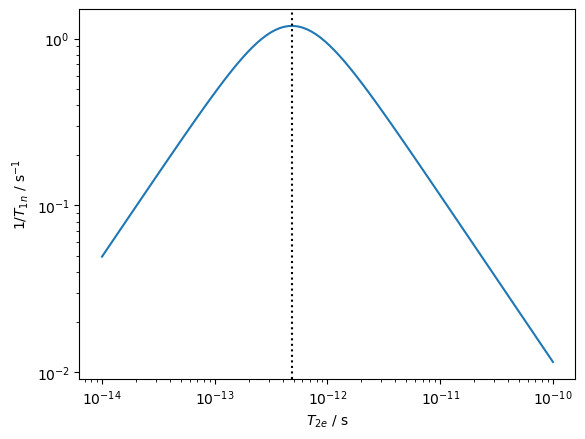

In [7]:
ax=plt.subplots()[1]
ax.loglog(T20,R1)
ax.set_ylim(ax.get_ylim())
T2max=1/(2*np.pi*np.abs(ex.v0[0]-ex.v0[1]))
ax.plot(T2max*np.ones(2),ax.get_ylim(),linestyle=':',color='black')
ax.set_xlabel(r'$T_{2e}$ / s')
_=ax.set_ylabel(r'$1/T_{1n}$ / s$^{-1}$')

Indeed, the minimum occurs as expected (we plot $1/T_{1n}$, so this appears as a maximum), where the dashed line marks the predicted minimum.

### Electron $T_1$ relaxation only

We next observe relaxation when only electron $T_1$ is present. This is unphysical, but we do it anyway to separate the two effects. Note that SLEEPY will warn us about the unphysicality.

In [8]:
L.clear_relax()
L.add_relax('T1',i=1,T1=1e-13)
seq=L.Sequence(Dt=1.0e-3)

rho=sl.Rho('13Cx+13Cz',['13Cp','13Cz','ez'])
_=rho.DetProp(seq,n=10000)

/Users/albertsmith/Documents/GitHub/SLEEPY/SLEEPY/Liouvillian.py:499: UserWarning: T1 relaxation included without T2 relaxation. Unphysical system
  warnings.warn('T1 relaxation included without T2 relaxation. Unphysical system')


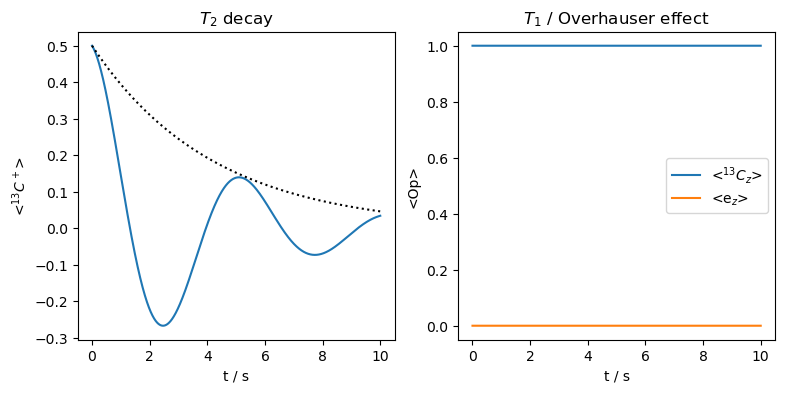

In [9]:
rho.downmix()
T1=2.1
ax=plt.subplots(1,2,figsize=[9,4])[1]
rho.plot(axis='s',det_num=0,ax=ax[0])
ax[0].set_title('$T_2$ decay')
ax[0].plot(rho.t_axis,0.5*np.exp(-rho.t_axis/(T1*2)),color='black',linestyle=':')
rho.plot(axis='s',det_num=[1,2],ax=ax[1])
_=ax[1].set_title(r'$T_1$ / Overhauser effect')

Then, we see that an electron $T_1$ acting via an isotropic hyperfine coupling induces $T_2$ decay, but no $T_1$ or Overhauser effect. As mentioned above, if we have electron $T_1$ and $T_2$ together, then we no longer have the case that $T_{2n}<T_{1n}.$ In fact, when $T_{1e}$=$T_{2e}$, then $T_{1n}$=$T_{2n}$. If $T_{1e}$ gets longer, then the $T_{2n}$ becomes shorter, giving the more typical case of $T_{1n}>T_{2n}$.

Below, we simulate the case that $T_{1e}=T_{2e}$, verifying that then $T_{1n}=T_{2n}$.

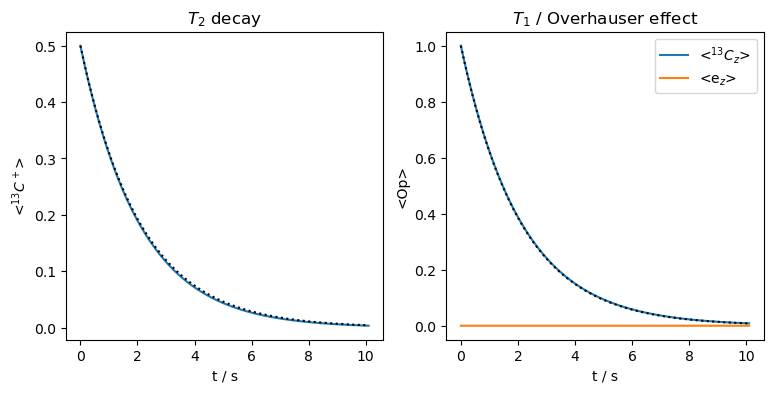

In [10]:
L.clear_relax()
L.add_relax('T1',i=1,T1=1e-13)
L.add_relax('T2',i=1,T2=1e-13)
seq=L.Sequence(Dt=1.01e-3)

rho=sl.Rho('13Cx+13Cz',['13Cp','13Cz','ez'])
_=rho.DetProp(seq,n=10000)
rho.downmix()
T1=2.1
ax=plt.subplots(1,2,figsize=[9,4])[1]
rho.plot(axis='s',det_num=0,ax=ax[0])
ax[0].set_title('$T_2$ decay')
ax[0].plot(rho.t_axis,0.5*np.exp(-rho.t_axis/T1),color='black',linestyle=':')
rho.plot(axis='s',det_num=[1,2],ax=ax[1])
ax[1].plot(rho.t_axis,np.exp(-rho.t_axis/T1),color='black',linestyle=':')
_=ax[1].set_title(r'$T_1$ / Overhauser effect')

Both $T_{2n}$ and $T_{1n}$ are approximately 2.1 seconds.

We can also acquire dependence of the nuclear $T_2$ on the electron $T_1$.

This is a little tricker than extracting the $T_1$. Decay rates are extracted from the real part of the eigenvalues of the propagators, but the relevant rates are easily identified because they are non-oscillating. For $T_2$, that is no longer the case, so that we simply search for the biggest term and extract its decay rate. This is not always the correct approach for extracting  decay of an oscillating signal, but works here because all the other terms are negligible.

In [11]:
rho=sl.Rho('13Cx','13Cp')
T10=np.logspace(-12,-1,200)
R2=[]
for T1 in T10:
    L.clear_relax()
    L.add_relax('T1',i=1,T1=T1) #Longer than all T2s used
    L.add_relax('T2',i=1,T2=1e-12)
    rate,_,A=rho.extract_decay_rates(L.U(Dt=1e-6),mode='all')
    i=np.argmax(A[0])
    R2.append(rate[0][i])

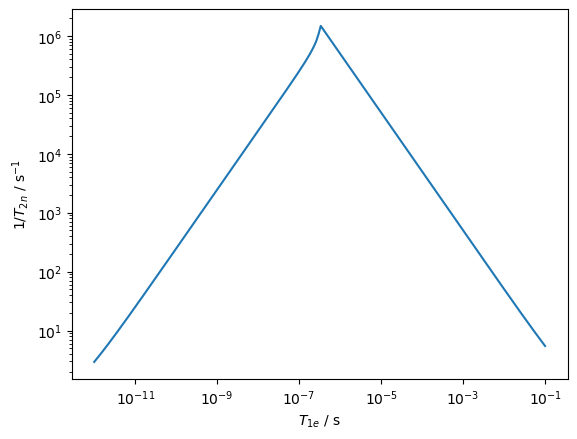

In [12]:
ax=plt.subplots()[1]
ax.loglog(T10,R2)
ax.set_ylim(ax.get_ylim())
ax.set_xlabel(r'$T_{1e}$ / s')
_=ax.set_ylabel(r'$1/T_{2n}$ / s$^{-1}$')

Then, as the electron $T_1$ gets longer, the nuclear $T_2$ gets shorter, resulting in a linear plot for short correlation times. However, when $1/T_1<2\pi A_{iso}\approx3x10^{-6}$ s$^{-1}$, the nuclear $T_2$ becomes longer again. A sharp transition occurs, similar to the coalescence condition found for simple [1D exchange](../Chapter2/Ch2_exchange1D.ipynb). Note that after this transition, we would observe two peaks, seen below.

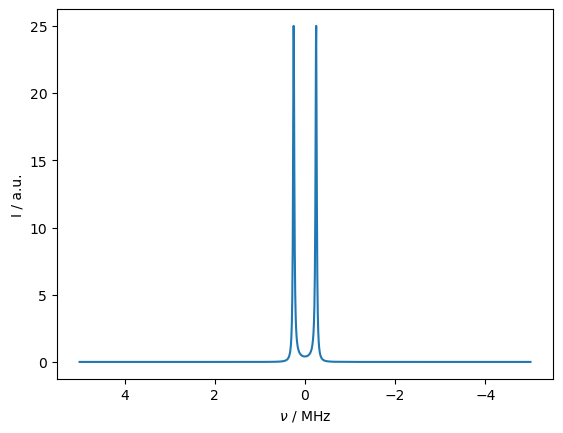

In [13]:
L.clear_relax()
L.add_relax('T1',i=1,T1=5e-6)
L.add_relax('T2',i=1,T2=1e-12)

rho.clear()
rho.DetProp(L.U(Dt=1e-7),n=1000)
rho.downmix()
_=rho.plot(FT=True)

## PRE from a dipolar hyperfine coupling

A dipolar hyperfine coupling will also induce paramagnetic relaxation enhancement, although the dependence of the nuclear relaxation on the electron $T_2$ and $T_1$ is different than the scalar case. We investigate this below. Note that now we use a powder-averaged system and magic angle spinning.

### Build the system

In [14]:
ex=sl.ExpSys(v0H=500,Nucs=['13C','e-'],LF=True,pwdavg=4)
delta=5e5
ex.set_inter(Type='hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)    #Hyperfine coupling

L=ex.Liouvillian()

### Electron $T_2$ relaxation only

In [15]:
L.clear_relax()
L.add_relax('T2',i=1,T2=5e-13,OS=True)
seq=L.Sequence()
U=seq**20

rho=sl.Rho('13Cx+13Cz',['13Cp','13Cz','ez'])
_=rho.DetProp(U,n=10000)

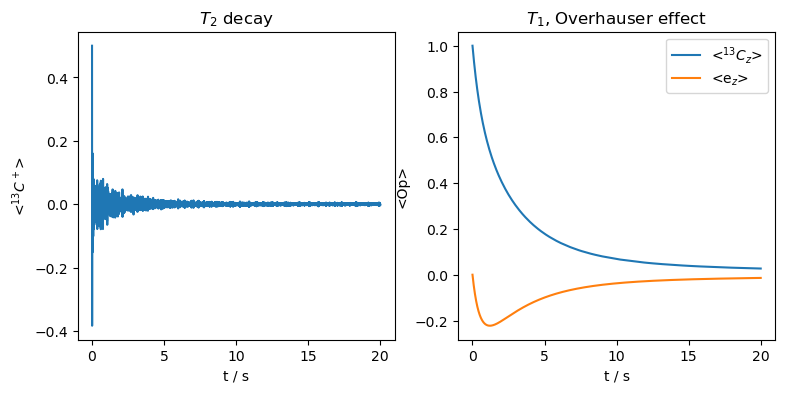

In [16]:
rho.downmix()
ax=plt.subplots(1,2,figsize=[9,4])[1]
rho.plot(axis='s',det_num=0,ax=ax[0])
ax[0].set_title('$T_2$ decay')
rho.plot(axis='s',det_num=[1,2],ax=ax[1])
_=ax[1].set_title(r'$T_1$, Overhauser effect')

Electron $T_2$ then similarly induces a nuclear $T_2$ and $T_1$. Unlike the scalar case, the $T_1$ is not a pure Overhauser effect transfer, and eventually the full magnetization is destroyed. 

The electron hyperfine coupling is strong enough to tilt the nuclear quantization axis away from the *z*, such that MAS can no longer average the coupling, yielding a complex lineshape if we Fourier transform the transverse magnetization. Note that this effect will only appear if the nucleus is in the lab frame.

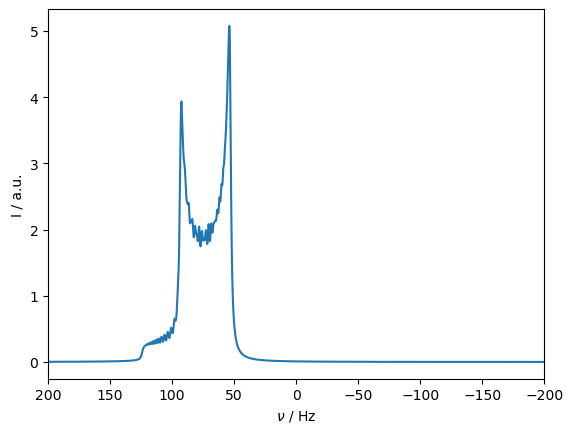

In [17]:
rho.apod_pars['LB']=2
_=rho.plot(FT=True,det_num=0,apodize=True).set_xlim([200,-200])

We can also sweep the electron $T_2$ to determine the dependence of the nuclear $T_1$ on the $T_2$.

In [18]:
# Takes a few minutes
ex=sl.ExpSys(v0H=500,Nucs=['13C','e-'],LF=True,pwdavg=2)
delta=5e5
ex.set_inter(Type='hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)    #Hyperfine coupling

L=ex.Liouvillian()

rho=sl.Rho('13Cz','13Cz')
T20=np.logspace(-14,-10,50)
R1=[]
for T2 in T20:
    L.clear_relax()
    L.add_relax('T2',i=1,T2=T2)
    R1.append(rho.extract_decay_rates(L.U()))

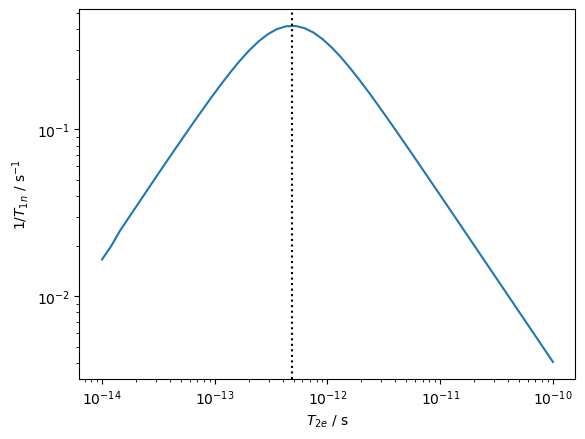

In [19]:
ax=plt.subplots()[1]
ax.loglog(T20,R1)
ax.set_ylim(ax.get_ylim())
T2max=1/(2*np.pi*np.abs(ex.v0[0]-ex.v0[1]))
ax.plot(T2max*np.ones(2),ax.get_ylim(),linestyle=':',color='black')
ax.set_xlabel(r'$T_{2e}$ / s')
_=ax.set_ylabel(r'$1/T_{1n}$ / s$^{-1}$')

As with the scalar hyperfine, we find the maximum at $T_{2e}=1/|(\omega_{0e}-\omega_{0n})|$.

### Electron $T_1$ relaxation only
Above, we saw the influence of the electron $T_{2e}$ on the nuclear $T_{1n}$ and $T_{2n}$, in the presence of a dipolar hyperfine coupling. Here, we investigate the influence of the electron $T_{1e}$.

In [20]:
ex=sl.ExpSys(v0H=500,Nucs=['13C','e-'],LF=True,pwdavg=4)
delta=5e5
ex.set_inter(Type='hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)    #Hyperfine coupling

L=ex.Liouvillian()

In [21]:
L.clear_relax()
L.add_relax('T1',i=1,T1=5e-13)
seq=L.Sequence()
U=seq**20

rho=sl.Rho('13Cx+13Cz',['13Cp','13Cz','ez'])
_=rho.DetProp(U,n=10000)

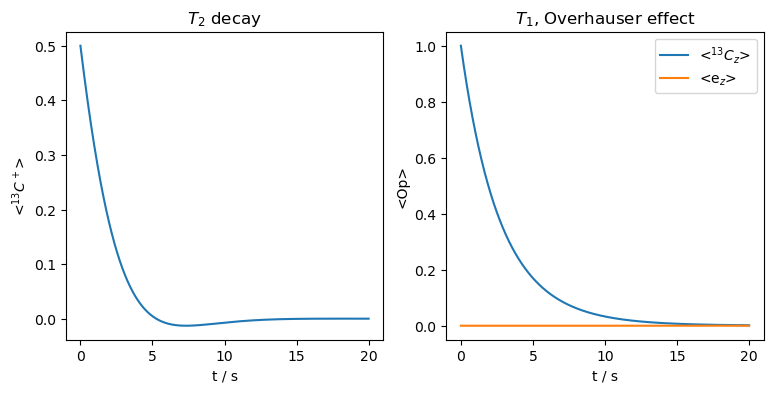

In [22]:
rho.downmix()
ax=plt.subplots(1,2,figsize=[9,4])[1]
rho.plot(axis='s',det_num=0,ax=ax[0])
ax[0].set_title('$T_2$ decay')
rho.plot(axis='s',det_num=[1,2],ax=ax[1])
_=ax[1].set_title(r'$T_1$, Overhauser effect')

As with the scalar hyperfine coupling, the electron $T_1$ relaxation induces $T_2$. $T_1$ relaxation is also induced on the nucleus, but without inducing any Overhauser effect. We can calculate the nuclear $T_1$ as a function of electron $T_1$, as is done below.

In [23]:
# Takes a few minutes
ex=sl.ExpSys(v0H=500,Nucs=['13C','e-'],LF=True,pwdavg=2)
delta=5e5
ex.set_inter(Type='hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)    #Hyperfine coupling

L=ex.Liouvillian()

rho=sl.Rho('13Cz','13Cz')
T10=np.logspace(-11,-7,50)
R1=[]
for T1 in T10:
    L.clear_relax()
    L.add_relax('T1',i=1,T1=T1)
    R1.append(rho.extract_decay_rates(L.U()))

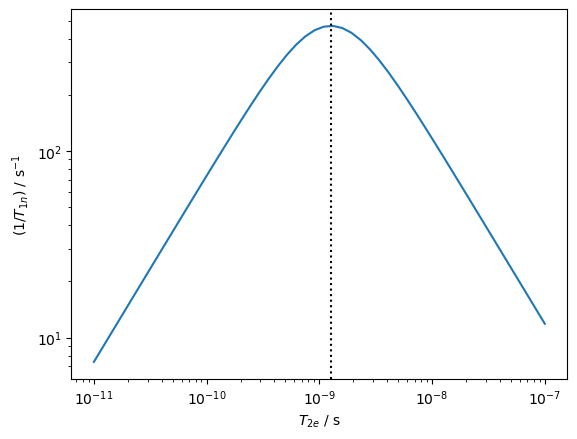

In [24]:
ax=plt.subplots()[1]
ax.loglog(T10,R1)
ax.set_ylim(ax.get_ylim())
T2max=1/(2*np.pi*np.abs(ex.v0[0]))
ax.plot(T2max*np.ones(2),ax.get_ylim(),linestyle=':',color='black')
ax.set_xlabel(r'$T_{2e}$ / s')
_=ax.set_ylabel(r'$(1/T_{1n})$ / s$^{-1}$')

We see that the maximum occurs when $T_{1e}=1/|(\omega_{0n})|$, in contrast to the results from the scalar hyperfine coupling where no nuclear $T_{1n}$ was induced by the electron $T_{1e}$